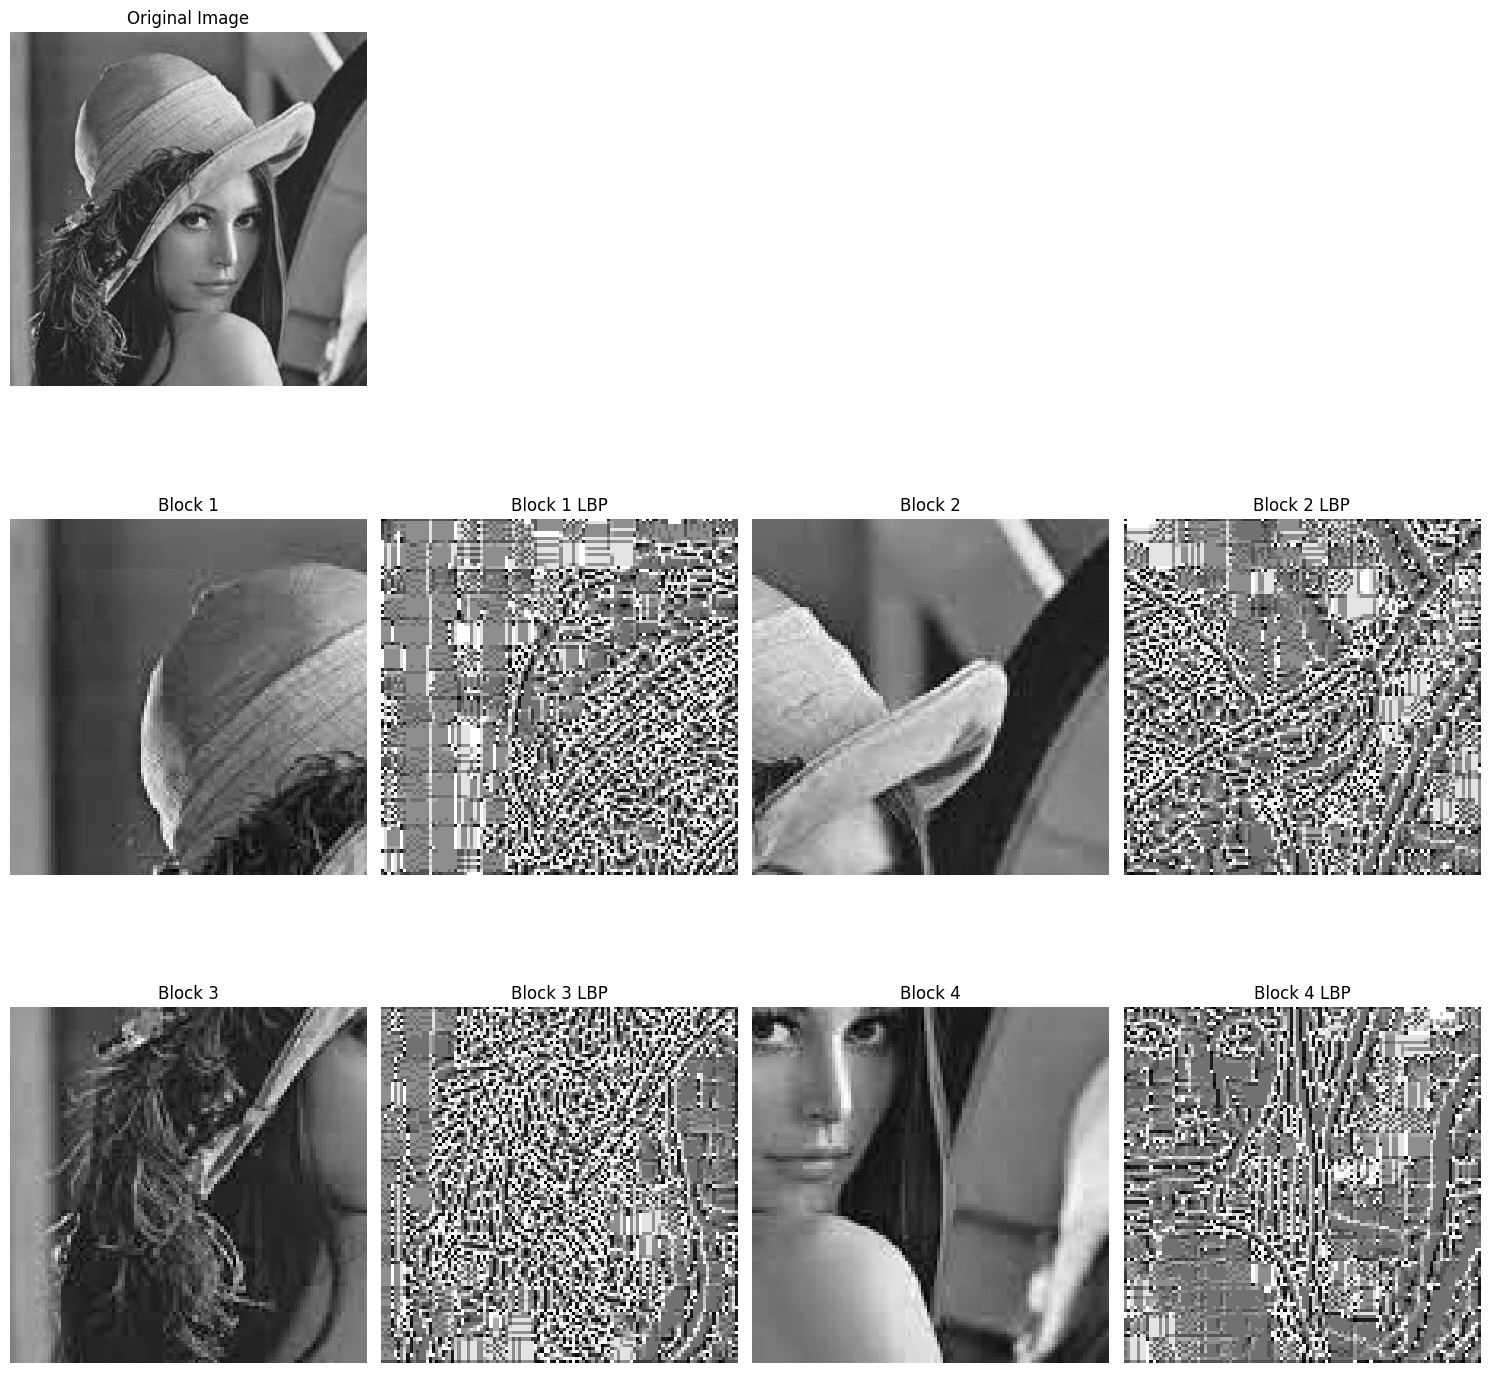

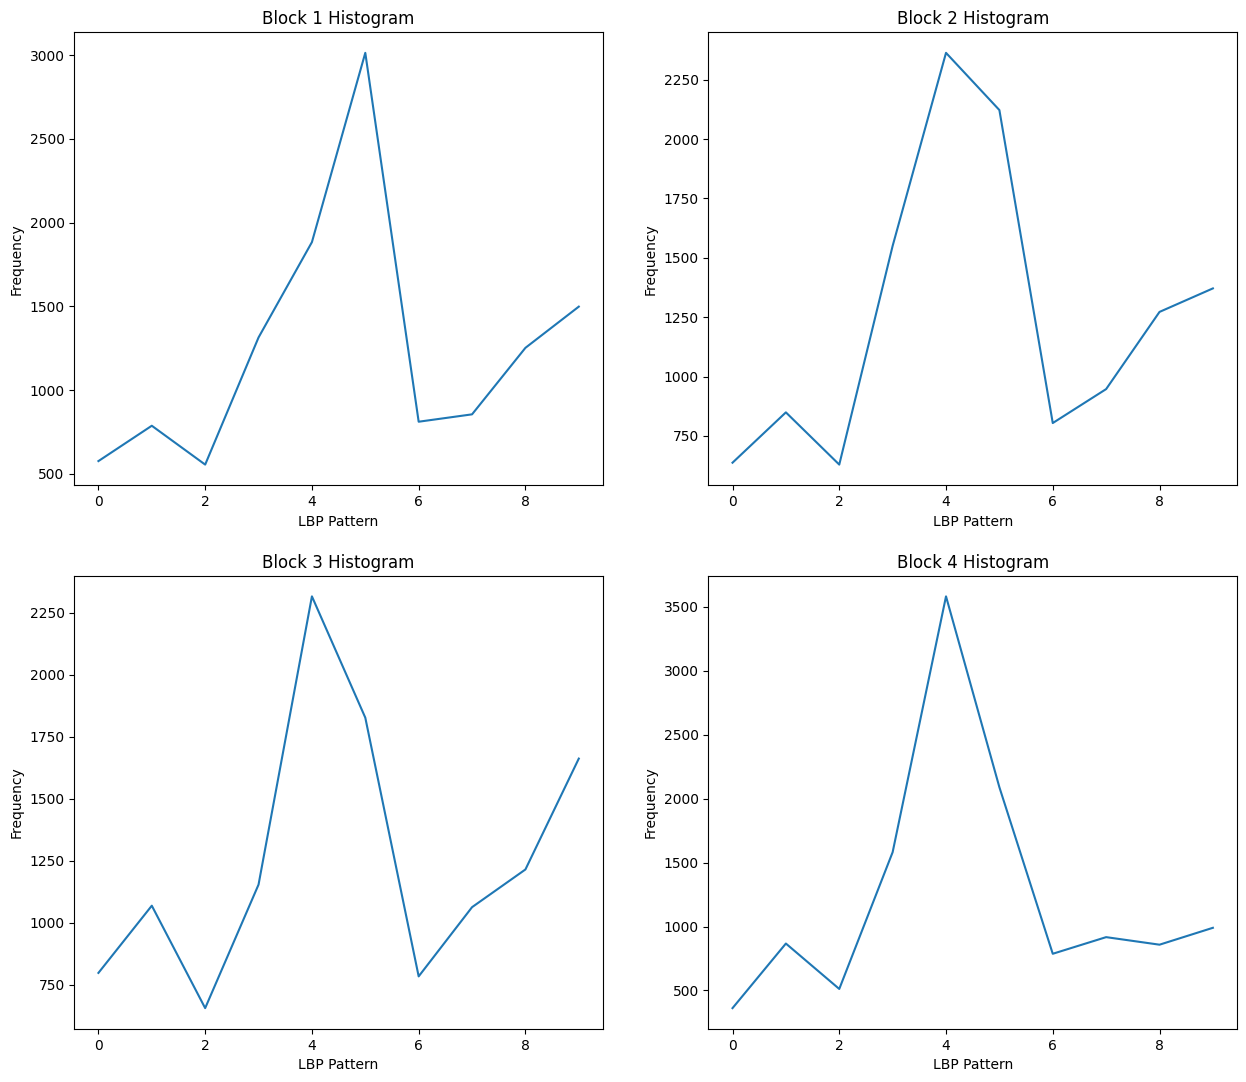

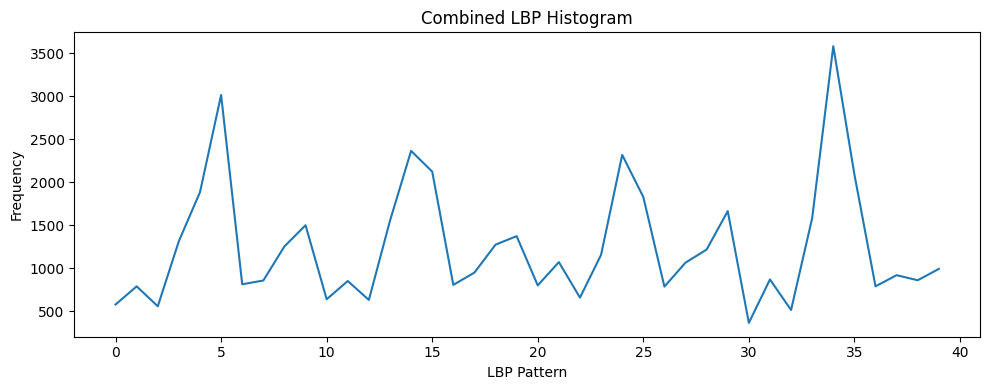

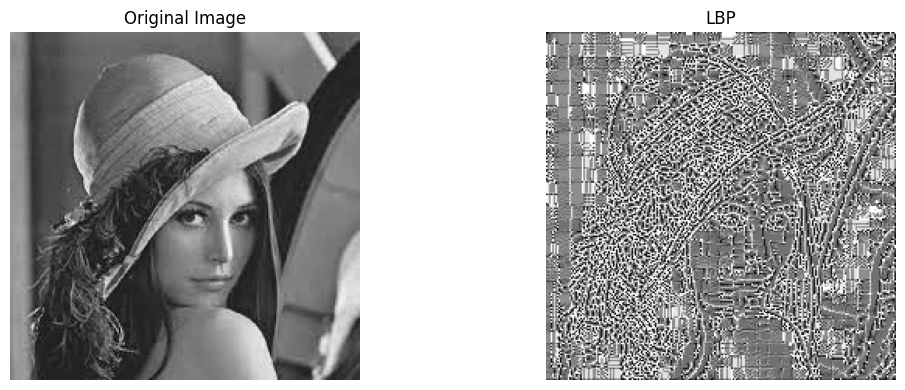

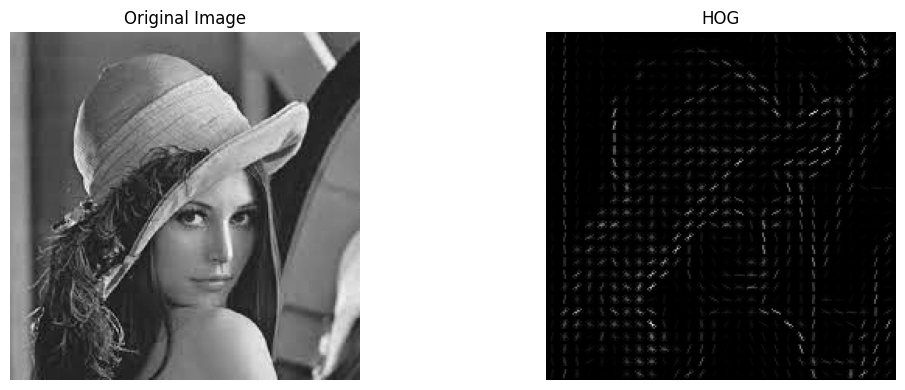

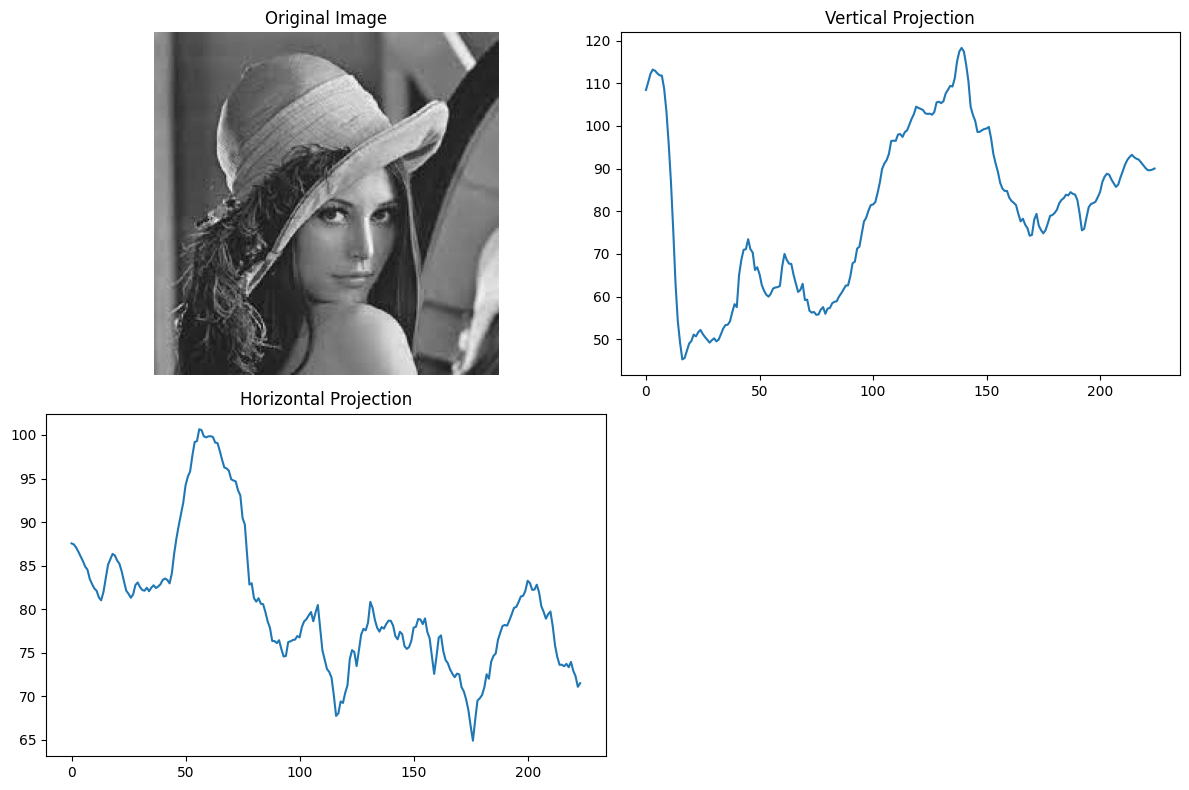

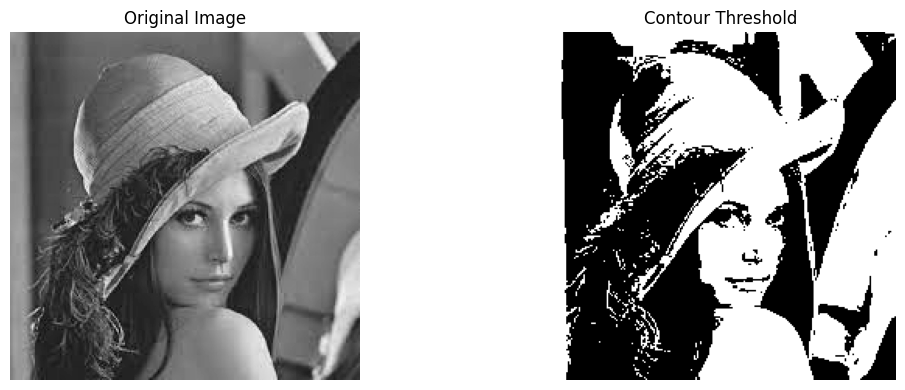

Total number of features: 26736


In [13]:
import numpy as np
import cv2
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage import io, color, img_as_ubyte
import matplotlib.pyplot as plt


def load_image(image_path):
    """Load and preprocess the image."""
    image = io.imread(image_path)
    if image.ndim == 3:
        image = color.rgb2gray(image)
    return image


def split_image_into_blocks(image, num_blocks):
    """Split image into num_blocks x num_blocks blocks."""
    if not (num_blocks & (num_blocks - 1) == 0):
        raise ValueError("Number of blocks must be a power of 2")

    height, width = image.shape
    block_height = height // num_blocks
    block_width = width // num_blocks

    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = image[
                i * block_height : (i + 1) * block_height,
                j * block_width : (j + 1) * block_width,
            ]
            blocks.append(block)

    return blocks


def extract_block_lbp(image, num_blocks, num_points=8, radius=1):
    """Extract LBP features for each block and combine them."""
    blocks = split_image_into_blocks(image, num_blocks)
    block_histograms = []
    block_lbps = []

    for block in blocks:
        lbp = local_binary_pattern(block, num_points, radius, method="uniform")
        # Calculate number of possible patterns for uniform LBP
        n_bins = num_points + 2
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        block_histograms.append(hist.astype("float"))
        block_lbps.append(lbp)

    combined_histogram = np.concatenate(block_histograms)
    return block_lbps, block_histograms, combined_histogram


def visualize_block_lbp(
    image, block_lbps, block_histograms, combined_histogram, num_blocks
):
    """Visualize original image, block-wise LBP patterns, and histograms."""
    # Create figure for blocks and their LBP patterns
    plt.figure(figsize=(15, 15))
    total_subplots = (num_blocks * num_blocks) * 2 + 1  # blocks, LBPs, and original
    cols = num_blocks * 2
    rows = num_blocks + 1

    # Plot original image
    plt.subplot(rows, cols, 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Plot blocks and their LBP patterns side by side
    for i in range(num_blocks * num_blocks):
        # Plot original block
        plt.subplot(rows, cols, cols + i * 2 + 1)
        block_size = image.shape[0] // num_blocks
        row = (i // num_blocks) * block_size
        col = (i % num_blocks) * block_size
        plt.imshow(image[row : row + block_size, col : col + block_size], cmap="gray")
        plt.title(f"Block {i+1}")
        plt.axis("off")

        # Plot LBP pattern
        plt.subplot(rows, cols, cols + i * 2 + 2)
        plt.imshow(block_lbps[i], cmap="gray")
        plt.title(f"Block {i+1} LBP")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # Create separate figure for histograms
    plt.figure(figsize=(15, 20))
    rows = (num_blocks * num_blocks) // 2 + 1
    cols = 2

    # Plot individual histograms
    for i, hist in enumerate(block_histograms):
        plt.subplot(rows, cols, i + 1)
        plt.plot(hist)
        plt.title(f"Block {i+1} Histogram")
        plt.xlabel("LBP Pattern")
        plt.ylabel("Frequency")

    # Plot combined histogram in a separate figure
    plt.figure(figsize=(10, 4))
    plt.plot(combined_histogram)
    plt.title("Combined LBP Histogram")
    plt.xlabel("LBP Pattern")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()


def extract_lbp(image, num_points=8, radius=1):
    """Extract Local Binary Pattern features."""
    lbp = local_binary_pattern(image, num_points, radius, method="uniform")
    # Calculate number of possible patterns for uniform LBP
    n_bins = num_points + 2
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    return lbp, hist.astype("float")


def extract_hog(image):
    """Extract Histogram of Oriented Gradients features."""
    fd, hog_image = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
    )
    return fd, hog_image


def extract_projection(image):
    """Extract horizontal and vertical projection features."""
    h_proj = np.sum(image, axis=1)
    v_proj = np.sum(image, axis=0)
    return np.concatenate([h_proj, v_proj])


def extract_contour(image):
    """Extract contour features."""
    image_8bit = img_as_ubyte(image)
    thresh = cv2.threshold(image_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        contour_areas = [cv2.contourArea(c) for c in contours]
        contour_perimeters = [cv2.arcLength(c, True) for c in contours]
        return (
            np.array(
                [len(contours), np.mean(contour_areas), np.mean(contour_perimeters)]
            ),
            thresh,
        )
    else:
        return np.zeros(3), thresh


def visualize_lbp(image, lbp):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(lbp, cmap="gray")
    plt.title("LBP")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def visualize_hog(image, hog_image):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(hog_image, cmap="gray")
    plt.title("HOG")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def visualize_projection(image, h_proj, v_proj):
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(222)
    plt.plot(v_proj)
    plt.title("Vertical Projection")
    plt.subplot(223)
    plt.plot(h_proj)
    plt.title("Horizontal Projection")
    plt.subplot(224)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def visualize_contour(image, thresh):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(thresh, cmap="gray")
    plt.title("Contour Threshold")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def extract_and_visualize_features(image_path, num_blocks=2):
    """Extract all features, combine them into a single descriptor, and visualize each feature."""
    image = load_image(image_path)

    # Block-wise LBP
    block_lbps, block_histograms, combined_histogram = extract_block_lbp(
        image, num_blocks
    )
    visualize_block_lbp(
        image, block_lbps, block_histograms, combined_histogram, num_blocks
    )

    # Regular LBP
    lbp, lbp_hist = extract_lbp(image)
    visualize_lbp(image, lbp)

    # HOG
    hog_features, hog_image = extract_hog(image)
    visualize_hog(image, hog_image)

    # Projection
    projection_features = extract_projection(image)
    h_proj = projection_features[: image.shape[0]]
    v_proj = projection_features[image.shape[0] :]
    visualize_projection(image, h_proj, v_proj)

    # Contour
    contour_features, thresh = extract_contour(image)
    visualize_contour(image, thresh)

    # Combine all features
    feature_descriptor = np.concatenate(
        [combined_histogram, hog_features, projection_features, contour_features]
    )

    return feature_descriptor


image_path = "lenna.png"
num_blocks = 2  # Must be a power of 2 (2, 4, 8, etc.)
features = extract_and_visualize_features(image_path, num_blocks)
print(f"Total number of features: {len(features)}")

<!-- 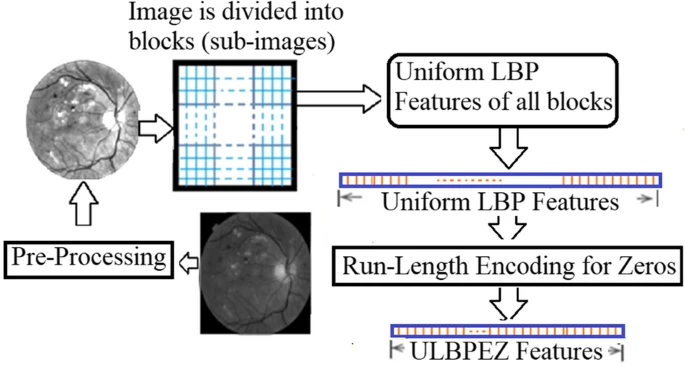 -->

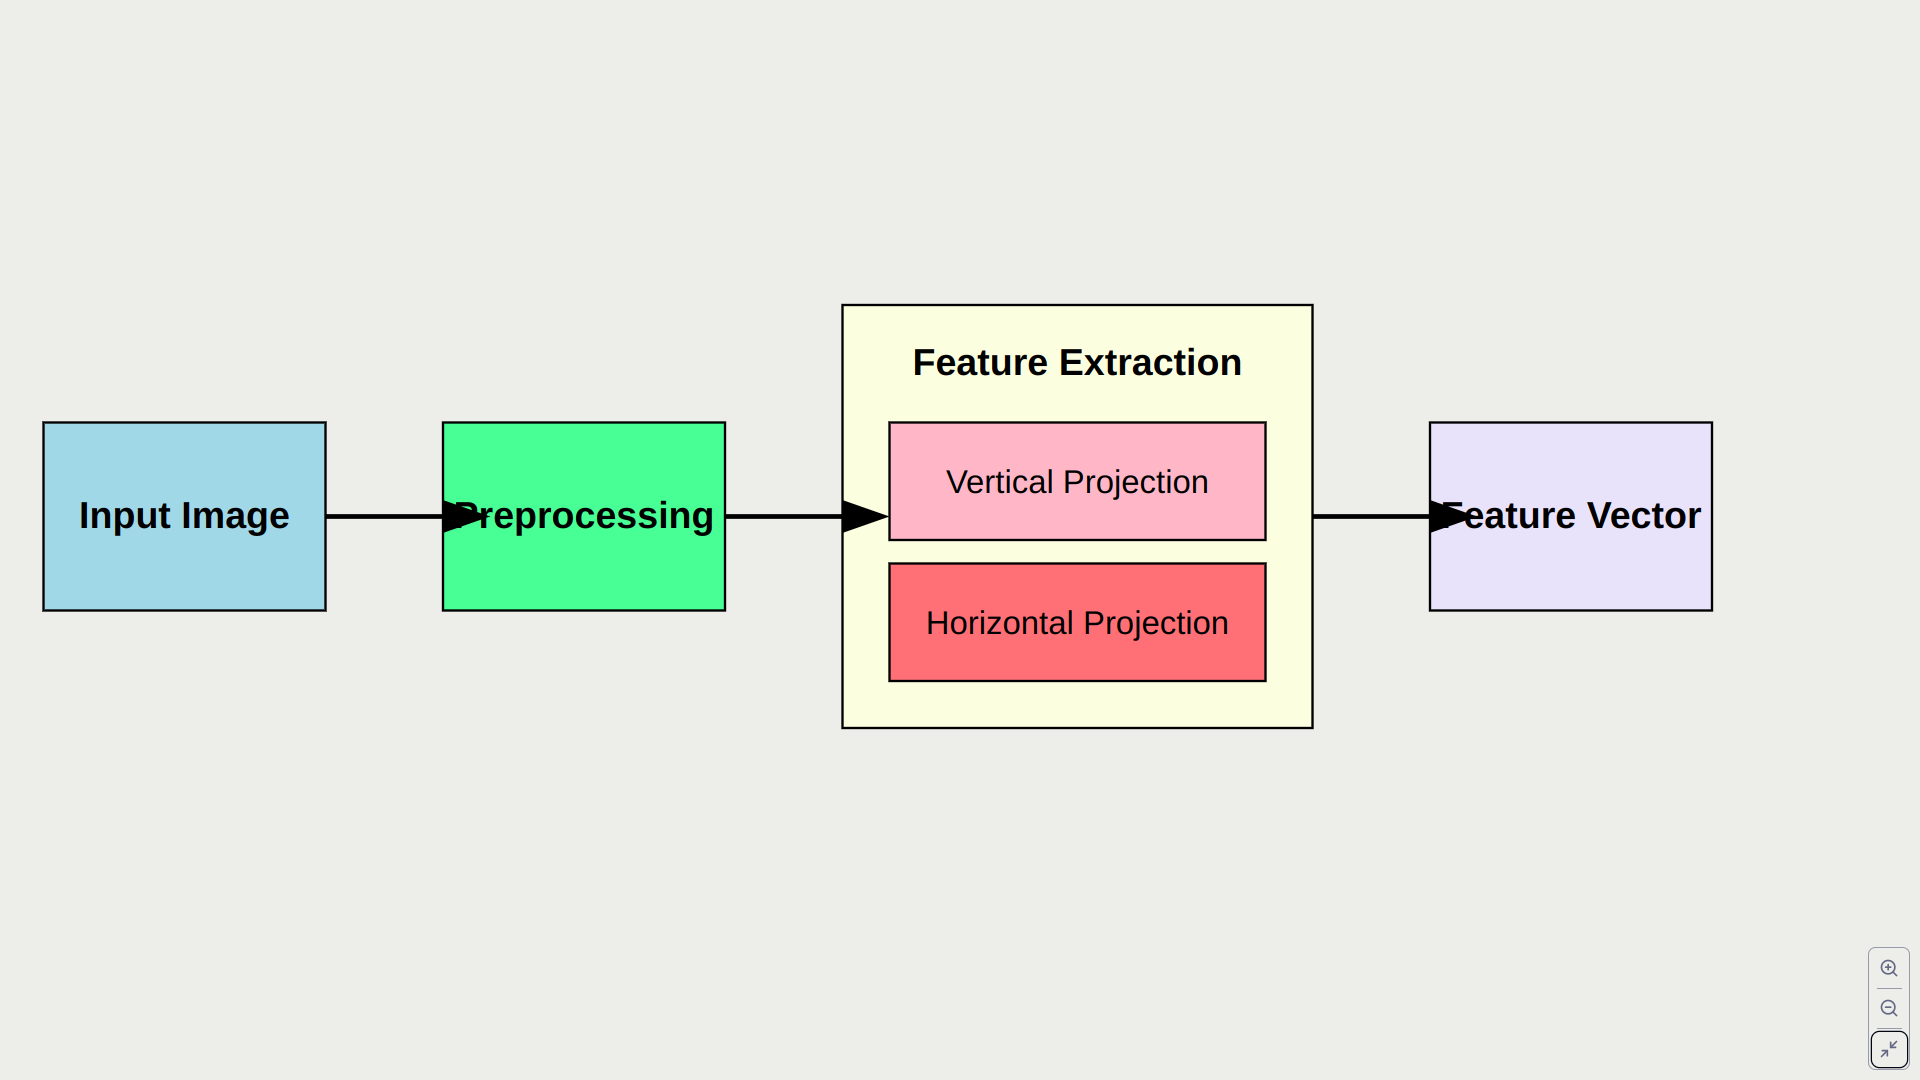

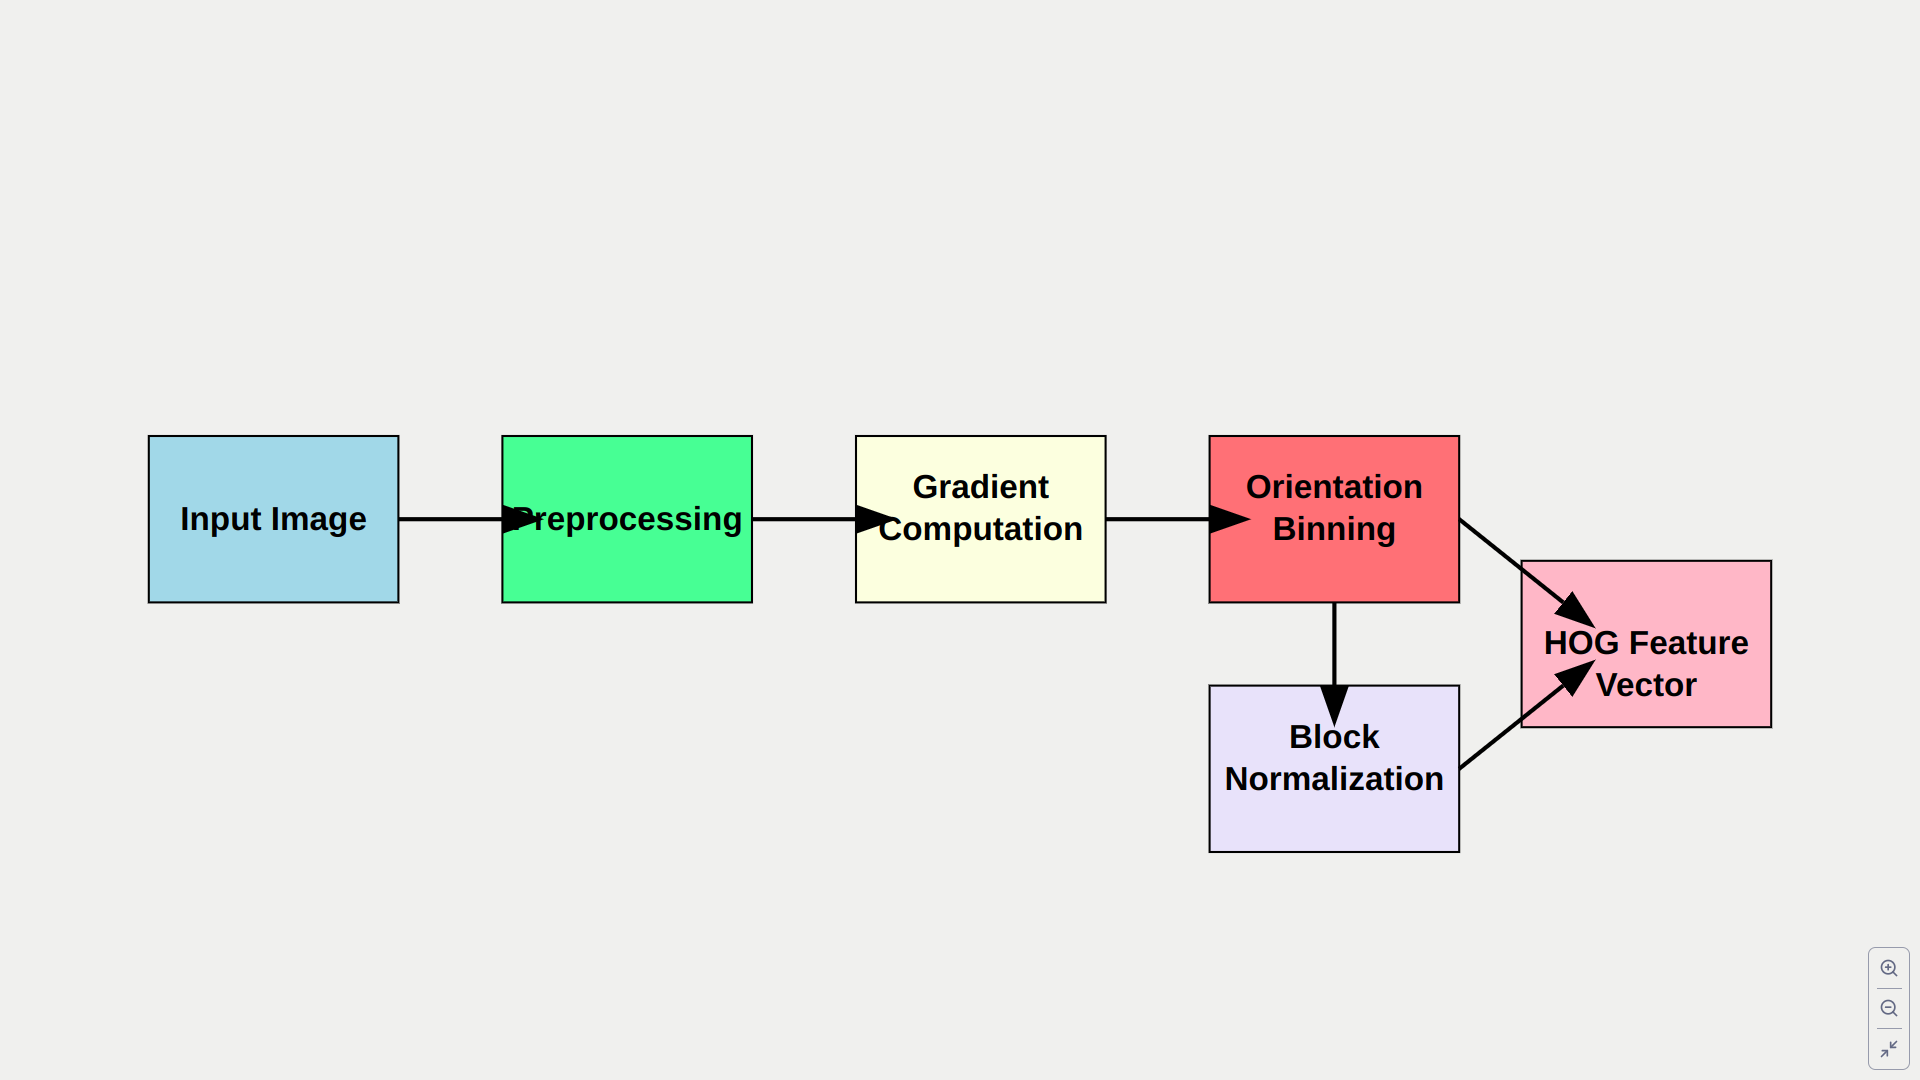

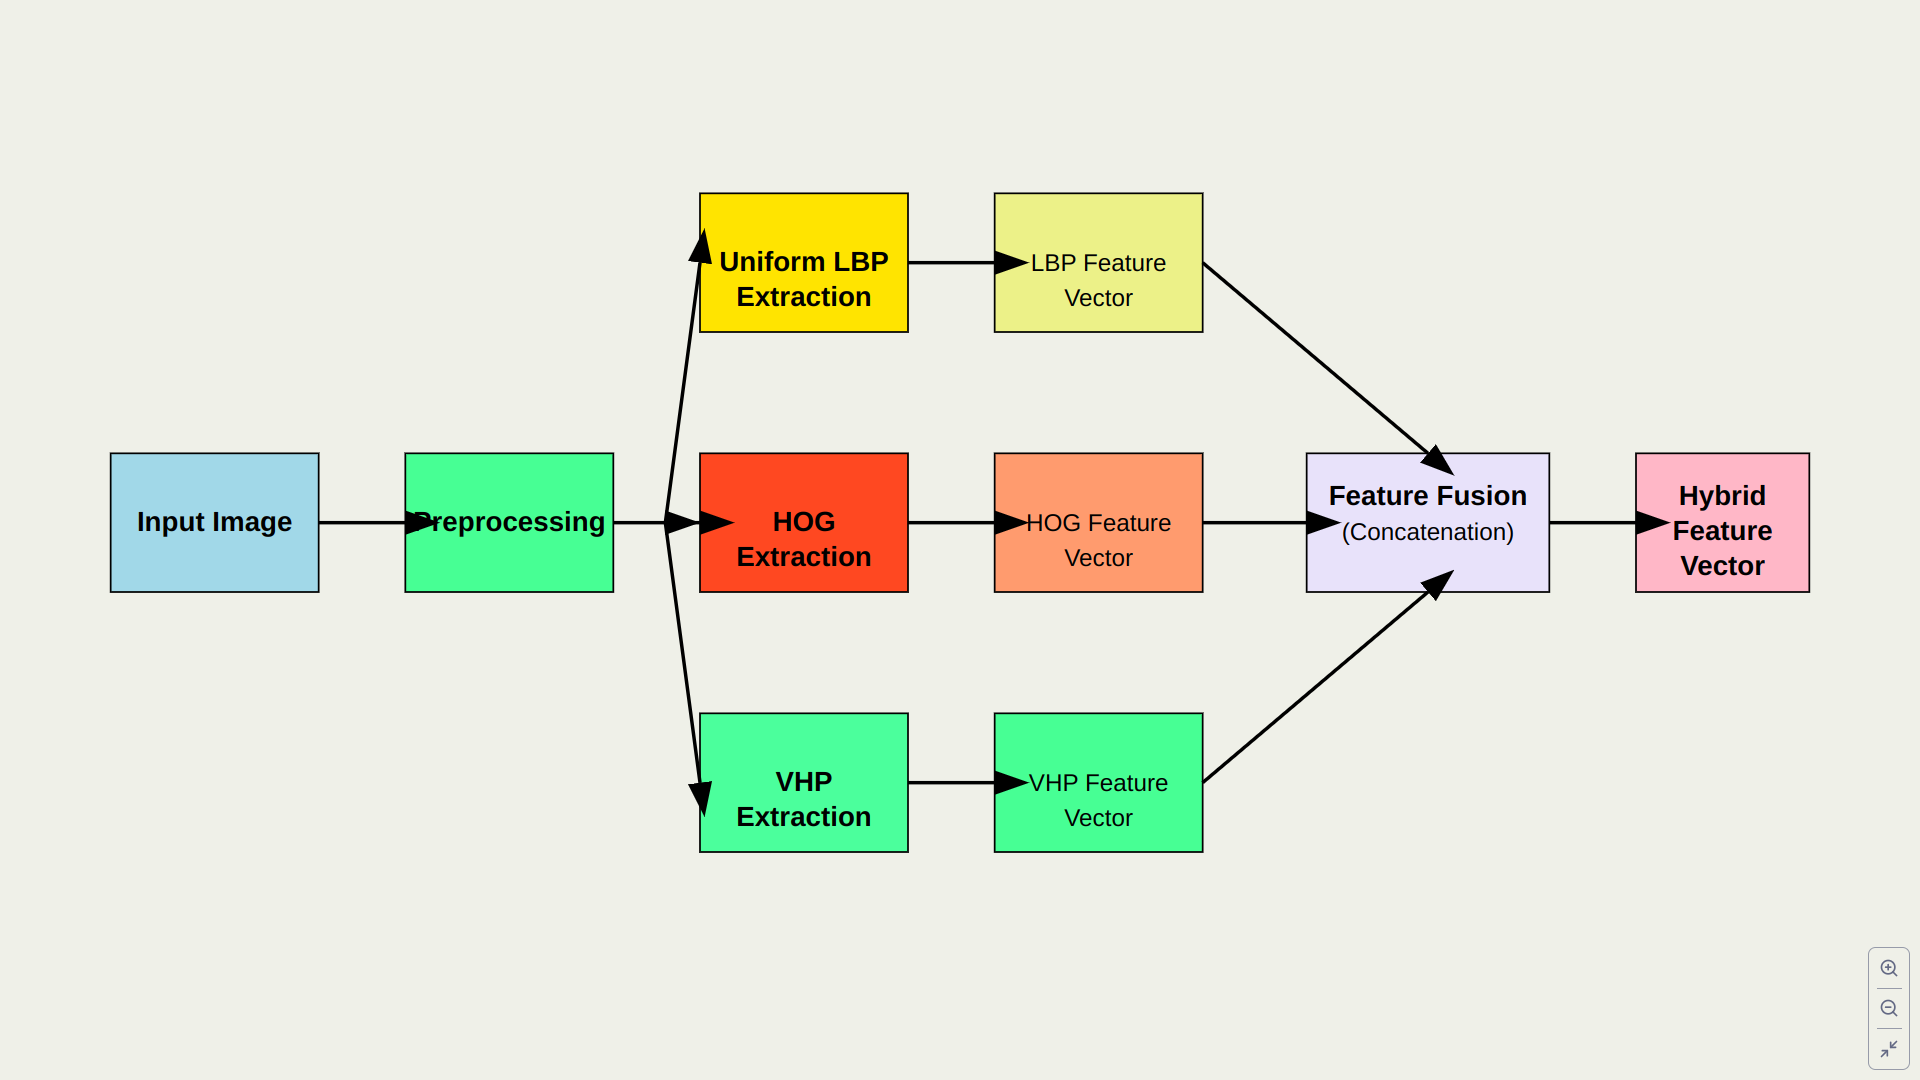